In [1]:
from collections import OrderedDict
import sys
from pathlib import Path
import json
import time
import math

import numpy as np
import matplotlib.pyplot as plt

import cv2

import kornia

import torch
import torch.nn as nn

import torchvision as tv
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import functional as tfunc

sys.path.append('../mine_soar')
import MalmoPython
from utils import draw_image, draw_layers

In [2]:
MISSION_PORT = 9001
VIDEO_SHAPE = (128, 128)
VIDEO_DEPTH = 3
DEVICE = 'cuda:0'
# DEVICE = 'cpu'

In [3]:
MALMO_HOST = MalmoPython.AgentHost()
malmo_client_info = MalmoPython.ClientInfo('127.0.0.1', MISSION_PORT)
malmo_client_pool = MalmoPython.ClientPool()
malmo_client_pool.add(malmo_client_info)

In [4]:
def start_mission(file="random_world.xml"):
    MALMO_HOST.sendCommand("quit")
    while MALMO_HOST.getWorldState().is_mission_running:
        time.sleep(0.1)
    time.sleep(0.2)
    mission_file = Path(file)
    random_world_mission_spec = MalmoPython.MissionSpec(mission_file.read_text(), True)
    random_world_record_spec = MalmoPython.MissionRecordSpec()
    MALMO_HOST.startMission(random_world_mission_spec, 
                                  malmo_client_pool,
                                  random_world_record_spec,
                                  0,
                                  "TEST ALPHA")

In [22]:
def get_mc_img(show=False, transform=None):
    state = MALMO_HOST.getWorldState()
    while state.number_of_video_frames_since_last_state < 1 or state.number_of_observations_since_last_state < 1:
        time.sleep(0.1)
        state = MALMO_HOST.getWorldState()
    image = np.frombuffer(state.video_frames[0].pixels, dtype=np.uint8)
    image = image.reshape(VIDEO_SHAPE+(4,))
    
    if VIDEO_DEPTH == 3:
        image = image[:,:,:3]
    image_tensor = tfunc.autocontrast(tfunc.to_tensor(image).to(DEVICE).unsqueeze(0))
    if transform:
        image_tensor = transform(image_tensor)
    
    obs = json.loads(state.observations[0].text)
    x = obs['XPos']
    y = obs['YPos']
    z = obs['ZPos']
    pitch = obs['Pitch']
    yaw = obs['Yaw']
    world_time = obs['WorldTime']
    life_time = obs['TimeAlive']
    agent_data = np.array([x, y, z, pitch, yaw, world_time, life_time]).astype(np.float32)
    agent_data_tensor = torch.Tensor(agent_data).to(DEVICE)
    
    if show:
        plt.imshow(image)
        plt.show()
        plt.close()
    return image, image_tensor, agent_data_tensor

In [11]:
start_mission()

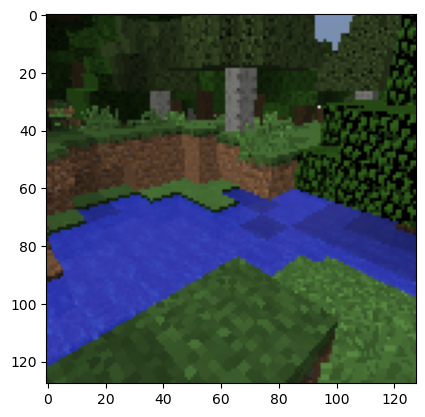

In [23]:
img, img_tens, agent_data = get_mc_img(True, kornia.color.rgb_to_lab)

In [32]:
img_laplacian = cv2.Laplacian(img, cv2.CV_64F)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


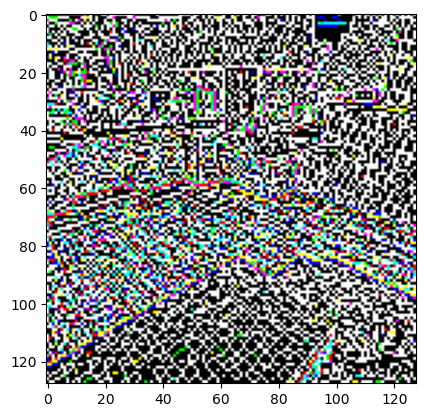

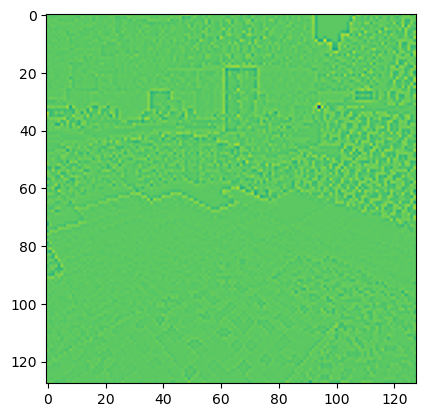

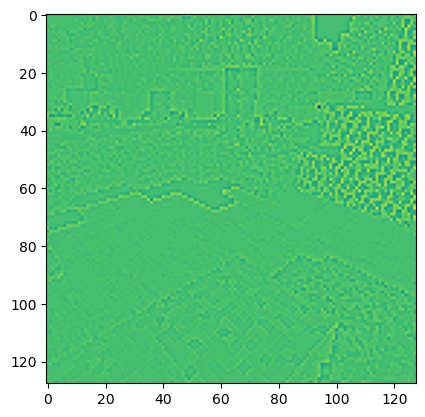

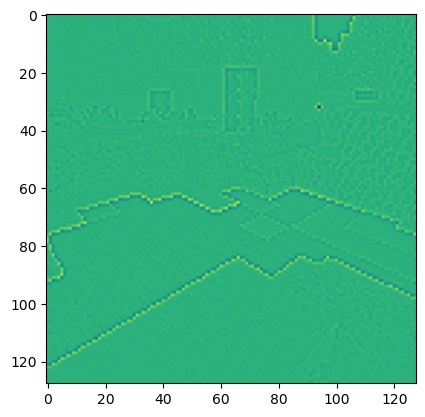

In [35]:
plt.imshow(img_laplacian)
plt.show()
plt.close()

plt.imshow(img_laplacian[:,:,0])
plt.show()
plt.close()

plt.imshow(img_laplacian[:,:,1])
plt.show()
plt.close()

plt.imshow(img_laplacian[:,:,2])
plt.show()
plt.close()

In [36]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_hsv_laplacian = cv2.Laplacian(img_hsv, cv2.CV_64F)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


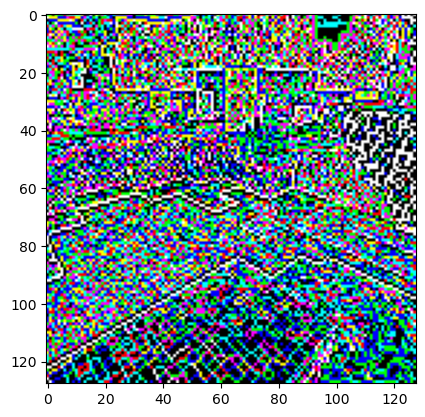

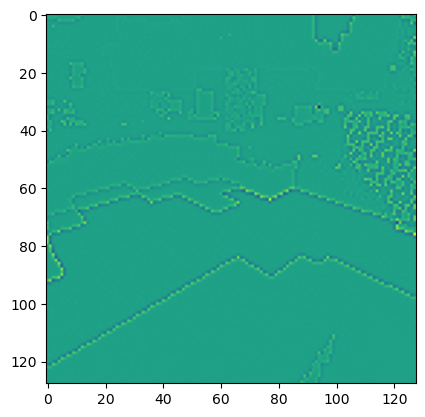

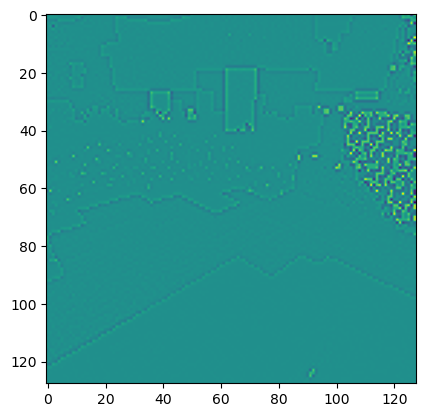

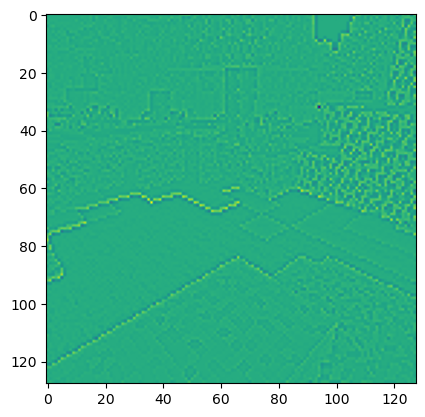

In [37]:
plt.imshow(img_hsv_laplacian)
plt.show()
plt.close()

plt.imshow(img_hsv_laplacian[:,:,0])
plt.show()
plt.close()

plt.imshow(img_hsv_laplacian[:,:,1])
plt.show()
plt.close()

plt.imshow(img_hsv_laplacian[:,:,2])
plt.show()
plt.close()

**Idea**: Symbols as generative models that can be used to explain away a part of an image, e.g., by subtrating the generated value from the image value and getting 0. Difference between vision and generation would eessentially be "interestingness" because it's the amount that can't be explained by what's known.

**Potential Pipeline:** Extract feature map where each feature is a lookup-key to an embeddings dict, embedding is decoded into a pixel value (e.g., RGB, HSV, LAB), subtracting from image, optimize to set everything in image to 0. Alternatively, do the same but directly on feature matps rather than img

What I want is a set of balls in feature/embedding space where the balls are look-up keys for combined symbols+generative models and the models (one model per ball) generate features/image data which matches what is seen

**What Needs to be Learned:**
- Feature map extractor to generate feature embeddings
- Set of generative models tied to locations in embedding space

In [80]:
test_conv = nn.Conv3d(1, 8, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect").to(DEVICE)

In [81]:
img_tens_3d = img_tens.unsqueeze(1)
print(img_tens_3d.shape)

torch.Size([1, 1, 3, 128, 128])


In [82]:
test_out = test_conv(img_tens_3d)
print(test_out.shape)

torch.Size([1, 8, 3, 128, 128])


In [83]:
test_conv2 = nn.Conv3d(8, 64, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect").to(DEVICE)
test_conv2(test_out).shape

torch.Size([1, 64, 3, 128, 128])

In [97]:
chans = 8
test_seq = nn.Sequential(
    nn.Conv3d(1, chans, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect"),
    nn.BatchNorm3d(chans),
    nn.ReLU(),
    nn.Conv3d(chans, chans, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect"),
    nn.BatchNorm3d(chans),
    nn.ReLU(),
    nn.Conv3d(chans, chans, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect"),
    nn.BatchNorm3d(chans),
    nn.ReLU(),
    #
    nn.Flatten(start_dim=1, end_dim=2),
    nn.Conv2d(chans*3, chans, 127, 1, 63)
#     nn.Conv3d(64, 8, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect"),
#     nn.BatchNorm3d(8),
#     nn.ReLU(),
#     nn.Conv3d(8, 1, (3, 127, 127), 1, (1, 63, 63), padding_mode="reflect"),
#     nn.Hardsigmoid()
).to(DEVICE)

In [98]:
test_seq_out = test_seq(img_tens_3d)
print(test_seq_out.shape)

torch.Size([1, 8, 128, 128])


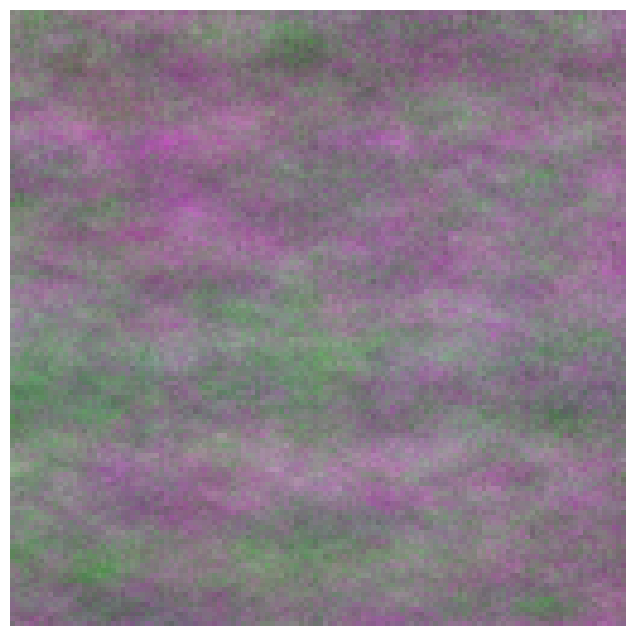

In [93]:
draw_image(test_seq_out[0][0], show=True)